# http://tau-data.id/umi/

<center><img alt="" src="images/0_Cover.jpg"/></center> 

## <center><font color="blue">Modul 08: Pendahuluan NLP & Text Preprocessing II</font></center>
<b><center>(C) Taufik Sutanto - 2019</center>
<center>tau-data Indonesia ~ https://tau-data.id ~ taufik@tau-data.id</center>

## <center><font color="blue">Pendahuluan NLP & Text Preprocessing II: Data Crawling & Sentiment Analysis</font></center>
<img alt="" src="images/PDS_logo.jpg" />

# <font color="blue">Workshop Schedule</font>

## <font color="green">Hari ke-4 (Kamis, 30 Jan 2020)</font>

**Pendahuluan Natural Language Processing & Text PreProcessing**
* 09:00 – 11:00 	Text Preprocessing
* 11:00 – 12:00	Crawling, Streaming, Scraping
* 13:00 – 14:00	Text Analytics
* 14:00 – 15.00	Sentiment Analysis
* 15:00 – 16.00	Latihan Text Analytics dan Sentiment Analysis 

Studi Kasus: **Text Analytics data media sosial perbincangan agama di media sosial**


In [ ]:
# Installing Modules for Google Colab
!wget https://raw.githubusercontent.com/taufikedys/UMI/master/taudata.py
!mkdir data
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/Tweets.json
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/dataTweet.txt
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/kataNegID.txt
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/kataPosID.txt
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/slang.dic
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/stopwords_id.txt
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/stopwords_en.txt
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/all_indo_man_tag_corpus_model.crf.tagger
!wget -P data/ https://raw.githubusercontent.com/taufikedys/UMI/master/data/kata_dasar.txt
!pip install unidecode
!pip install pyLDAvis
!pip install textblob
!pip install sastrawi
!pip install twython
!pip install tweepy
!pip install spacy
!pip install python-crfsuite
!python -m spacy download en
!python -m spacy download xx
!python -m spacy download en_core_web_sm
import nltk
nltk.download('popular')

In [2]:
import taudata as tau, seaborn as sns; sns.set()
import tweepy, json, nltk, urllib.request
from textblob import TextBlob
from nltk.tokenize import TweetTokenizer
from twython import TwythonStreamer  
from tqdm import tqdm_notebook as tqdm
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## <font color="blue">Outline Sentiment Analysis :</font>

* Corpus-Based Sentiment Analysis
* Metode Supervised untuk Sentiment Analysis 

<p><img alt="" src="images/9_Sentiment_Analysis_Meme.jpg" style="height:300px; width:400px" /></p>


<p><strong>Apakah sentiment analysis?</strong></p>

<p>Sentiment Analysis adalah suatu proses komputasi untuk menentukan apakah suatu penrnyataan bermakna positive, negative, atau netral.</p>

<p>Terkadang disebut juga sebagai&nbsp;<strong>opinion mining.</strong></p>

<p><strong>Contoh aplikasi Sentiment Analysis</strong></p>

<ul>
	<li><strong>Business: tanggapan konsumen atas suatu produk</strong>.</li>
	<li><strong>Politics:&nbsp;</strong>Sentimen masyarakat sebagai strategi pemenangan pemilu/pilkada.</li>
</ul>


<p><img alt="" src="images/9_SA_techniques.jpg" style="height:300px; width:536px" /></p>


In [4]:
# Lexicon Based berdasarkan 
# pattern = https://www.clips.uantwerpen.be/pages/pattern-en#sentiment
Sentence = "I love Bakpia so much it's delicious"
T = TextBlob(Sentence)
print(T.sentiment)
print('Polarity=Sentimen =', testimonial.sentiment.polarity)

Sentiment(polarity=0.75, subjectivity=0.8)
Polarity=Sentimen = 0.75


## Bagaimana Dengan Bahasa Indonesia?
<p>[A simple trick]</p>

In [12]:
kalimat = 'coto Kuda mantep tenan euy'
K = TextBlob(kalimat).translate(to='en')
K

TextBlob("coto Horse is very nice")

In [6]:
def SenSub_ID(kalimat):
    K = TextBlob(kalimat).translate(to='en')
    pol,sub = K.sentiment
    if pol>0:
        pol='positive'
    elif pol<0:
        pol='negative'
    else:
        pol = 'netral'
    if sub>0.5:
        sub = 'Subjektif'
    else:
        sub = "Objektif"
    return pol, sub

In [13]:
kalimat = 'hari ini cerah'
SenSub_ID(kalimat)

('netral', 'Objektif')

In [14]:
from textblob.sentiments import NaiveBayesAnalyzer
# Warning, mungkin lambat karena membentuk model classifier* terlebih dahulu.
# *Berdasarkan NLTK corpus ==> Language dependent
Sentence = "Textblob is amazingly simple to use"
blob = TextBlob(Sentence, analyzer=NaiveBayesAnalyzer())
blob.sentiment
# Good Explanation: https://medium.com/nlpython/sentiment-analysis-analysis-ee5da4448e37
# Output probabilitas prediksinya

Sentiment(classification='pos', p_pos=0.7952586206896557, p_neg=0.2047413793103446)

## Bagaimana dengan Sentiment Analysis menggunakan NBC untuk Bahasa indonesia?

In [24]:
def word_feats(words):
    return dict([(word, True) for word in words])

def bentukClassifier(P, Ne, Nt):
    positive_features = [(word_feats(pos), 'pos') for pos in P]
    negative_features = [(word_feats(neg), 'neg') for neg in Ne]
    neutral_features = [(word_feats(neu), 'neu') for neu in Nt]
    train_set = negative_features + positive_features + neutral_features
    return NaiveBayesClassifier.train(train_set)

def prediksiSentiment(sentence, model):
    pos, neg = 0, 0
    words = sentence.lower().split(' ') # sebaiknya menggunakan n-gram
    for word in words:
        classResult = model.classify( word_feats(word) )
        if classResult == 'neg':
            neg = neg + 1
        if classResult == 'pos':
            pos = pos + 1
    if pos>neg:
        return 'positif'
    elif pos==neg:
        return 'netral'
    else:
        return 'negatif'

In [29]:
P = [ 'keren', 'suka', 'cinta', 'bagus', 'mantap', 'sadis', 'top']
emot_pos = [':)', ':D', "<3"]
Ne = [ 'jelek', 'benci','buruk', 'najis']
emot_neg = [':(', ":'("]
Nt = [ 'bakso','film','pisang','pagi','makan','kopi','minum','sambil','abis']

model = bentukClassifier(P, Ne, Nt) 

sentence = "makan pempek minumnya teh panas mantap"
prediksiSentiment(sentence,model)

'positif'

# Negasi?

In [30]:
Negasi = ['tidak', 'ngga', 'engga', 'enggak', 'ndak', 'endak', 'tdk']
Pos = P + [n +' '+ ne for n,ne in zip(Negasi, Ne)] + emot_pos
Neg = Ne + [n +' '+ po for n,po in zip(Negasi, P)] + emot_neg

print(Pos, Neg)

['keren', 'suka', 'cinta', 'bagus', 'mantap', 'sadis', 'top', 'tidak jelek', 'ngga benci', 'engga buruk', 'enggak najis', ':)', ':D', '<3'] ['jelek', 'benci', 'buruk', 'najis', 'tidak keren', 'ngga suka', 'engga cinta', 'enggak bagus', 'ndak mantap', 'endak sadis', 'tdk top', ':(', ":'("]


# Lexicon?

In [31]:
Pos = [t.strip() for t in tau.LoadDocuments(file = 'data/kataPosID.txt')[0]]
Neg = [t.strip() for t in tau.LoadDocuments(file = 'data/kataNegID.txt')[0]]

print(len(Pos), len(Neg))
print(Pos[:10],'\n', Neg[:10])

1295 3548
['absah', 'absolut', 'accord', 'acuan', 'adil', 'aduhai', 'afdol', 'ahli', 'akademisi', 'akan bayar'] 
 ['acak-acakan', 'adiktif', 'adu', 'adu domba', 'aduh', 'aib', 'akal bulus', 'akting', 'alasan saja', 'alibi']


## Bagaimana jika mau melakukannya dengan model klasifikasi (supervised learning) lain seperti modul sebelumnya?
(e.g. SVM, NN, DT, k-NN, etc)

In [32]:
# text Classification : independent variable
d1 = 'Minum kopi pagi-pagi sambil makan pisang goreng is the best'
d2 = 'Belajar NLP dan Text Mining ternyata seru banget'
d3 = 'Palembang agak mendung hari ini'
d4 =  'Sudah lumayan lama tukang Bakso belum lewat'
d5 = 'Aduh ga banget makan Mie Ayam pakai kecap, please deh'
d6 = 'Benci banget kalau melihat orang buang sampah sembarangan di jalan'
d7 = 'Kalau liat orang ga taat aturan rasanya ingin ngegampar aja'
d8 = 'Nikmatnya meniti jalan jalan penuh romansa di tengah kota bernuansa pendidikan'
d9 = 'kemajuan bangsa ini ada pada kegigihan masyarakat dalam belajar dan bekerja'
D = [d1,d2,d3,d4,d5,d6,d7,d8,d9]
'Done!'

'Done!'

In [33]:
# dependent variable, misal 0=positif, 1=netral, 2=negatif
Class = [0,0,1,1,2,2,2,1,0]
dic = {0:'positif', 1:'netral', 2:'negatif'}
print([dic[c] for c in Class])

['positif', 'positif', 'netral', 'netral', 'negatif', 'negatif', 'negatif', 'netral', 'positif']


In [43]:
# Bentuk VSM-nya seperti kemarin (skip preprocessing)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vsm = vectorizer.fit_transform(D)

print(vsm.shape)
str(vectorizer.vocabulary_)[:30]

(9, 144)


"{'minum': 91, 'kopi': 65, 'pag"

In [37]:
# Lakukan klasifikasi (misal dengan SVM)
dSVM = svm.SVC(kernel='linear')
sen = dSVM.fit(vsm, Class).predict(vsm)
print(accuracy_score(Class, sen))
# Memakai seluruh training data karena sampel yang sangat kecil

1.0


# Better yet, gunakan vocabulary-based VSM dan-atau Post-Tag

<h2 id="Supplementary">Supplementary</h2>

<p>* Negasi suatu kata bukan berarti memiliki sentimen kebalikannya. Misal &quot;jelek&quot; dan &quot;tidak jelek&quot; (terrible vs not terrible).</p>

<p><img alt="" src="images/negation_sentiments.png" /></p>

<p>[*]. Zhu, X., Guo, H., Mohammad, S., &amp; Kiritchenko, S. (2014). An empirical study on the effect of negation words on sentiment. In&nbsp;<i>Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)</i>&nbsp;(Vol. 1, pp. 304-313).</p>


* Makna positive/negative atau pro/kontra subjective (bias) terhadap user.
* StopWords removal in general is a bad idea
* learn the lingo in your topic, sentiment expressions are different across fields, languages, and regions.
* Sarcasm perlu konteks untuk di deteksi dengan tepat.

<h2 id="Feature-Engineering/Extraction">Feature Engineering/Extraction</h2>

<ul>
	<li>Ketimbang pemilihan model yang optimal, beberapa literature sudah melaporkan bahwa feature engineering/extraction lebih efektif [1].</li>
	<li>Selain itu, pendekatan semantic dalam FE juga lebih plausible untuk dilakukan.</li>
	<li>Tabel berikut adalah contoh FE yang bisa dilakukan spesifik terhadap model SA.</li>
	<li><img alt="" src="images/SA_Analysis_Features.png" style="width: 544px; height: 425px;" /></li>
</ul>


# Catatan penting di Sentimen Analysis:

1. Hati-hati melakukan stopwords dan frequency filtering.
2. Menggunakan Post-Tag Adjective dan-atau vocabulary-based VSM dapat membantu model sentiment analysis
3. feature engineering lebih penting ketimbang model yang kompleks.
4. Corpus bisa jadi harus berbeda untuk setiap konteks.

# Latihan:

1. Lakukan Sentimen Analysis pada data Tweet menggunakan himpunan Lexicon diatas.
2. Membuat piechart proporsi sentimen
3. Memisahkan seluruh Tweet yang pos, neg, dan netral
4. Apakah hasilnya cukup baik? Apa yang bisa dilakukan untuk memperbaiki hasil?
5. Export masing-masing ke text file untuk dianalisa lebih lanjut (misal text analytics) 

In [44]:
# stopId, lemmaId = tau.LoadStopWords(lang='id') 
slangFixId = tau.loadCorpus(file = 'data/slang.dic', sep=':')

In [45]:
T2 = tau.loadTweets(file='data/Tweets.json')
D = [t['full_text'] for t in T2] # Tweet hasil crawling
data = []
for i, d in tqdm(enumerate(D)):
    doc = tau.cleanText(d, fix=slangFixId, symbols_remove = True, min_charLen = 3, max_charLen = 12, fixTag= True, fixMix=True)
    data.append(doc)
print(data[:3])


['reishaac makassar bias adalah orang yang paling percaya diri dan tukang promosi disaat member lain pakai masker hanya dia sendiri yang tidak dengan alasan ingin seluruh dunia lihat ketampanan dia member tertua grup yang membuat suka dan jatuh cinta dalam sekali lihat', 'hai tsuV tsu amaoell ayobantu retweet coba lihat tokotamz pinbb jual sepatu baju aksesoris cewek makassar', 'hai ayobantu retweet coba lihat tokotamz pinbb jual sepatu baju aksesoris cewek makassar']


In [ ]:
# Jawaban di cell ini


# <center><font color="blue"> End of Module 08

<hr />
<p><img alt="" src="images/6_SocMed_cartoon.png" /></p>

In [46]:
Pos = [t.strip() for t in tau.LoadDocuments(file = 'data/kataPosID.txt')[0]]
Neg = [t.strip() for t in tau.LoadDocuments(file = 'data/kataNegID.txt')[0]]

print(Pos[:10])

['absah', 'absolut', 'accord', 'acuan', 'adil', 'aduhai', 'afdol', 'ahli', 'akademisi', 'akan bayar']


In [47]:
vectorizer = TfidfVectorizer()
vsm = vectorizer.fit_transform(data)
All_words = list(vectorizer.vocabulary_.keys())
All_lexicon = set(Pos+Neg)
Net = [kata for kata in All_words if kata not in All_lexicon]

Net[:7]

['reishaac', 'makassar', 'adalah', 'orang', 'yang', 'paling', 'diri']

In [48]:
model = bentukClassifier(Pos, Neg, Net) 

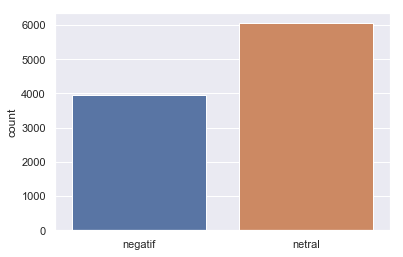

In [49]:
prediksi = []
for tweet in tqdm(data):
    prediksi.append(prediksiSentiment(tweet,model))
    
plot = sns.countplot(prediksi)

In [50]:
# Notes: disini saya menggunakan "D" dan bukan "data"
negatif_data = [d for d,p in zip(D, prediksi) if p=='negatif']

negatif_data[:7]

['@reishaac @BTS_twt Makassar @BTS_twt \nBias ku adalah orang yg paling pede dan tukang promosi, disaat member lain pakai masker hanya dia sendiri yg tdk dengan alasan ingin seluruh dunia liat ketampanan dia, member tertua di grup yg membuat ku suka dan jatuh Cinta dlm sekali lihat,',
 'BUKBER cassandrasleee &amp; bryandomani__BD Makassar 9july htm:500,350,250,200,more info?hub:MiftahulIlmiR,andidianita1',
 'RT @TanpaPolitik: @sigitigisigit Bahkan kemarin temanku naik bus dari Makassar ke Morowali utara katanya seisi bus kebanyakan orang china.…',
 'RT @TanpaPolitik: @sigitigisigit Bagaimana caranya kalau tidak banyak?\nSaya orang Morowali kok, kemarin dari jogja naik pesawat, berhenti d…',
 'RT @Indostransfer: OFFICIAL: Persija resmi memboyong Gelandang asal Belanda, Marc Anthony Klok (26).\n\nBersama PSM Makassar selama 3 tahun,…',
 'PSM Makassar Pastikan Lepas Marc Klok, Persija Jadi yang Terdepan https://t.co/GpYkj2QB6r',
 '🦉 Owl of Sex 🦉\n🅷🅰🅿🅿🆈 🅲🆁🅾🅾🆃🆃🆉\n\n  💘 @MyCandyPanLok\n  💘 @